In [3]:
!unzip -qq "/content/drive/MyDrive/archive.zip"

Начало

In [1]:
#библиотеки
import pandas as pd
import numpy as np
import gc
import os

from tensorflow.keras import layers, Input
from keras.layers import InputLayer, MaxPooling2D, Flatten, Dense, Conv2D, Dropout
from keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

from PIL.Image import open

from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import random

In [2]:
columns = ["Image", "Class"]
dataset_df = pd.read_csv("/content/Brain Tumor.csv", usecols=columns)
dataset_df

,Image,Class
0,Image1,0
1,Image2,0
2,Image3,1
3,Image4,1
4,Image5,0
...,...,...
3757,Image3758,0
3758,Image3759,0
3759,Image3760,0
3760,Image3761,0


In [3]:
print(dataset_df.shape)

(3762, 2)


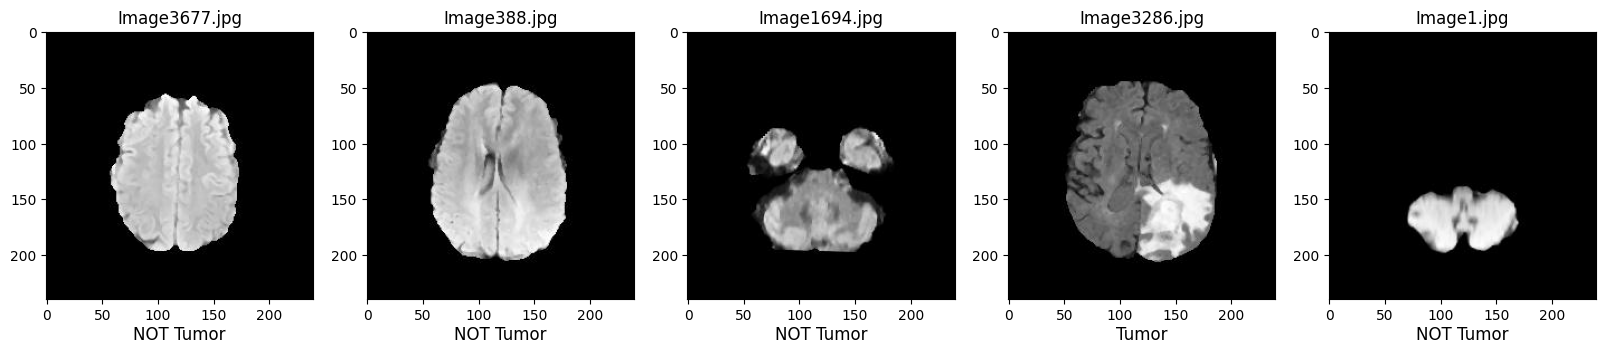

In [4]:
#Сами изображения
plt.figure(figsize=(20,20))
img_folder="/content/Brain Tumor/Brain Tumor"
for i in range(5):
    file = random.choice(os.listdir(img_folder))
    img_name = file.split('.')[0]
    img_class = dataset_df.loc[dataset_df['Image'] == img_name, 'Class'].iloc[0]
    image_path= os.path.join(img_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    text_class = "Tumor" if img_class == 1 else "NOT Tumor"
    ax.text(0.5, -0.15, text_class, size=12, ha="center", transform=ax.transAxes)
    plt.imshow(img)

In [5]:
#Параметры
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS = 3

In [6]:
route = "/content/Brain Tumor/Brain Tumor/"
dataset_df["pixels"] = [
    np.asarray(open(os.path.join(route, name + ".jpg")).resize((IMG_HEIGHT, IMG_WIDTH)))
    for name in dataset_df["Image"]
]

In [7]:
dataset_df

,Image,Class,pixels
0,Image1,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,Image2,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,Image3,1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,Image4,1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,Image5,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
...,...,...,...
3757,Image3758,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3758,Image3759,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3759,Image3760,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3760,Image3761,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [8]:
x = np.empty((len(dataset_df), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.float32)
for i in range(len(dataset_df)):
    image = dataset_df["pixels"][i].astype(np.float32) / 255
    x[i] = image
x.shape

(3762, 224, 224, 3)

In [9]:
y = np.array(dataset_df.Class)
y.shape

(3762,)

In [10]:
#Делим на обучающую и тестовую
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15)
print('The shape of the x_train :'+' '+str(x_train.shape))
print('The size of the x_train :'+' '+str(x_train.shape[0]))
print('The shape of the x_test :'+' '+str(x_test.shape))
print('The size of the x_test:'+' '+str(x_test.shape[0]))

The shape of the x_train : (3197, 224, 224, 3)
The size of the x_train : 3197
The shape of the x_test : (565, 224, 224, 3)
The size of the x_test: 565


In [11]:
#Делим уже обучающую выборку на валидационную и обучающую соответственно
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15)
print('The shape of the x_train :'+' '+str(x_train.shape))
print('The size of the x_train :'+' '+str(x_train.shape[0]))
print('The shape of the x_val :'+' '+str(x_val.shape))
print('The size of the x_val:'+' '+str(x_val.shape[0]))

The shape of the x_train : (2717, 224, 224, 3)
The size of the x_train : 2717
The shape of the x_val : (480, 224, 224, 3)
The size of the x_val: 480


In [90]:
def my_model(given_shape):
  model = Sequential([

      Input(shape=given_shape),

      Conv2D(16, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"),
      Conv2D(16, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"),
      MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'),

      Conv2D(32, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"),
      Conv2D(32, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"),
      MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'),

      Conv2D(64, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"),
      Conv2D(64, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"),
      MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'),

      Flatten(),
      Dense(256, activation="relu"),
      Dropout(0.1),
      Dense(128, activation="relu"),
      Dense(1, activation="sigmoid")
  ])
  return model

In [91]:
model = my_model(given_shape = (IMG_HEIGHT, IMG_WIDTH, CHANNELS))

In [92]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 112, 112, 16)      448       
                                                                 
 conv2d_25 (Conv2D)          (None, 56, 56, 16)        2320      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 28, 28, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 14, 14, 32)        4640      
                                                                 
 conv2d_27 (Conv2D)          (None, 7, 7, 32)          9248      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 4, 4, 32)          0         
 ng2D)                                                

In [93]:
myOpt = SGD(learning_rate=0.01, nesterov=True)
loss_fn = BinaryCrossentropy()
model.compile(optimizer=myOpt, loss=loss_fn, metrics=['accuracy'])

In [94]:
EPOCHS = 30
BATCH_SIZE = 10

In [95]:
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=(x_val, y_val))

Epoch 1/30
272/272 [==============================] - 25s 87ms/step - loss: 0.5812 - accuracy: 0.6739 - val_loss: 0.5162 - val_accuracy: 0.7563
Epoch 2/30
272/272 [==============================] - 24s 88ms/step - loss: 0.4909 - accuracy: 0.7722 - val_loss: 0.5218 - val_accuracy: 0.7521
Epoch 3/30
272/272 [==============================] - 24s 89ms/step - loss: 0.4585 - accuracy: 0.7921 - val_loss: 0.4767 - val_accuracy: 0.7688
Epoch 4/30
272/272 [==============================] - 22s 83ms/step - loss: 0.4292 - accuracy: 0.8090 - val_loss: 0.4433 - val_accuracy: 0.8146
Epoch 5/30
272/272 [==============================] - 22s 81ms/step - loss: 0.3956 - accuracy: 0.8230 - val_loss: 0.3896 - val_accuracy: 0.8292
Epoch 6/30
272/272 [==============================] - 25s 91ms/step - loss: 0.3568 - accuracy: 0.8414 - val_loss: 0.3907 - val_accuracy: 0.8562
Epoch 7/30
272/272 [==============================] - 23s 84ms/step - loss: 0.3328 - accuracy: 0.8469 - val_loss: 0.3827 - val_accuracy:

In [96]:
print("Проверка:")
eval_score = model.evaluate(x_test, y_test)
print('Eval loss:',eval_score[0])
print('Eval accuracy:',eval_score[1])

Проверка:
18/18 [==============================] - 3s 132ms/step - loss: 0.1242 - accuracy: 0.9628
Eval loss: 0.12424595654010773
Eval accuracy: 0.9628318548202515


1/1 [==============================] - 0s 25ms/step


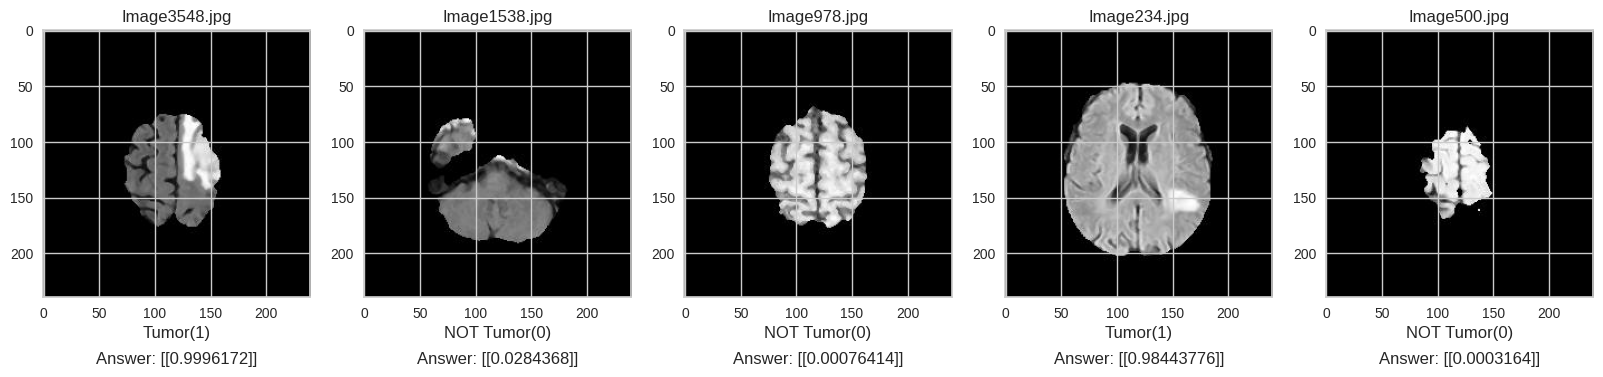

In [97]:
# Наглядная демонстрация работы нейросети
plt.figure(figsize=(20,20))
img_folder="/content/Brain Tumor/Brain Tumor"
for i in range(5):
    image_df = dataset_df.sample(n=1)
    image_name = image_df['Image'].iloc[0]
    image_name = image_name + ".jpg"
    image_class = image_df['Class'].iloc[0]
    image_path= os.path.join(img_folder, image_name)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(image_name)
    text_class = "Tumor(1)" if image_class == 1 else "NOT Tumor(0)"
    ax.text(0.5, -0.15, text_class, size=12, ha="center", transform=ax.transAxes)
    image = (image_df['pixels'].iloc[0]).astype(np.float32) / 255
    image = image.reshape(1,224,224,3)
    prediction = model.predict(image)
    ax.text(0.5, -0.25, f'Answer: {prediction}', size=12, ha="center", transform=ax.transAxes)
    plt.imshow(img)

In [98]:
loss = history.history["loss"]
acc = history.history["accuracy"]

val_loss = history.history["val_loss"]
val_accuracy = history.history["val_accuracy"]

epoch = history.epoch

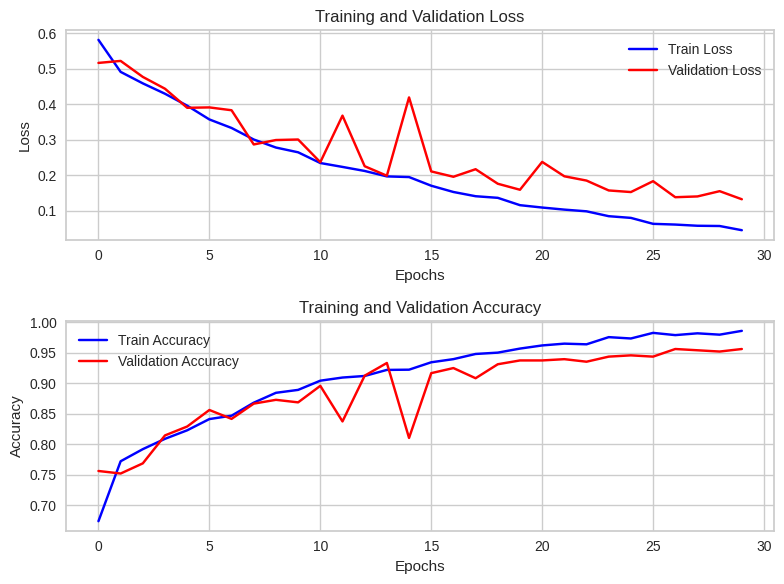

In [99]:
# Графики процесса обучения
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# График Train & Validation Loss
ax1.plot(epoch, loss, label='Train Loss', color='blue')
ax1.plot(epoch, val_loss, label='Validation Loss', color='red')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Training and Validation Loss')

# График Train & Validation Accuracy
ax2.plot(epoch, acc, label='Train Accuracy', color='blue')
ax2.plot(epoch, val_accuracy, label='Validation Accuracy', color='red')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

18/18 [==============================] - 3s 190ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       303
           1       0.98      0.93      0.95       262

    accuracy                           0.96       565
   macro avg       0.96      0.96      0.96       565
weighted avg       0.96      0.96      0.96       565



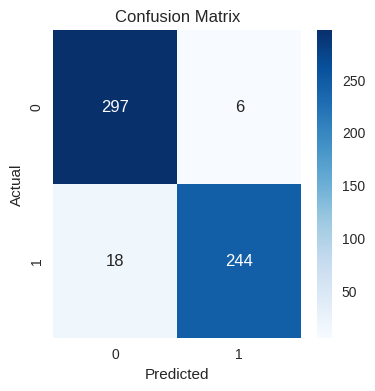

In [100]:
# Confusion Matrix
y_pred_probs = model.predict(x_test)
y_pred = np.where(y_pred_probs[:, 0] > 0.7, 1, 0)

cm = confusion_matrix(y_test, y_pred)

# Построение матрицы ошибок
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Вывод отчета о классификации
print("Classification Report:\n", classification_report(y_test, y_pred))


18/18 [==============================] - 1s 71ms/step


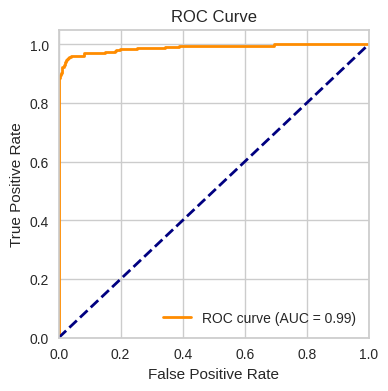

In [101]:
# ROC-AUC
y_pred_probs = model.predict(x_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs[:,0], pos_label=1)
roc_auc = auc(fpr, tpr)  # площадь под ROC-кривой (AUC)

# Построение ROC-кривой
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [104]:
# Сохраняем модель и выгружаем ее в виде архива на Google Drive
model.save("myCNN_brain_tumor")
!tar -zcvf myCNN_brain_tumor.tar.gz /content/myCNN_brain_tumor
!mv /content/myCNN_brain_tumor.tar.gz /content/drive/MyDrive/kaggle

tar: Removing leading `/' from member names
/content/myCNN_brain_tumor/
/content/myCNN_brain_tumor/fingerprint.pb
/content/myCNN_brain_tumor/keras_metadata.pb
/content/myCNN_brain_tumor/assets/
/content/myCNN_brain_tumor/variables/
/content/myCNN_brain_tumor/variables/variables.data-00000-of-00001
/content/myCNN_brain_tumor/variables/variables.index
/content/myCNN_brain_tumor/saved_model.pb
